# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# April 12, 2018

## Advanced Shape and Texture

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Literature / Useful References

### Books
- Jean Claude, Morphometry with R
- [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
- [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
- Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 

*** 
### Papers / Sites
- Thickness
 - [1] Hildebrand, T., & Ruegsegger, P. (1997). A new method for the model-independent assessment of thickness in three-dimensional images. Journal of Microscopy, 185(1), 67–75. doi:10.1046/j.1365-2818.1997.1340694.x
- Curvature
 - http://mathworld.wolfram.com/MeanCurvature.html
 - [2] "Computation of Surface Curvature from Range Images Using Geometrically Intrinsic Weights"*, T. Kurita and P. Boulanger, 1992.
 - http://radiomics.io

# Outline

- Motivation (Why and How?)
- What are Distance Maps?
- What are thickness maps?

***

- Characteristic Shapes
- Texture Analysis

# Learning Objectives

### Motivation (Why and How?)

- How can we measure sizes in complicated objects?
- How do we measure sizes relavant for diffusion or other local processes?

- How do we investigate surfaces in more detail and their shape?
- How can we compare shape of complex objects when they grow?
 - Are there characteristic shape metrics?
 
*** 

- How to we quantify patterns inside images?
- How can compare between different patterns?
- How can we quantify as radiologists say *looking evil*?

# Distance Maps: What are they

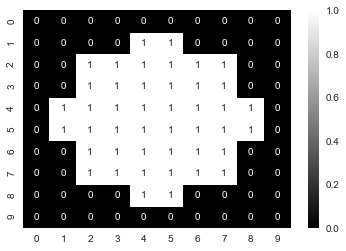

In [14]:
%matplotlib inline
import numpy as np
import skimage.transform
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import os


def generate_dot_image(size=100, rad_a=1, rad_b=None):
    xx, yy = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    if rad_b is None:
        rad_b = rad_a
    return np.sqrt(np.square(xx/rad_a)+np.square(yy/rad_b)) <= 1.0


img_bw = generate_dot_image(10, 0.8)

sns.heatmap(img_bw, annot=True,
            fmt="d", cmap='gray')

A map (or image) of distances. Each point in the map is the distance that point is from a given feature of interest (surface of an object, ROI, center of object, etc)

In [3]:
help(ndimage.distance_transform_edt)

Help on function distance_transform_edt in module scipy.ndimage.morphology:

distance_transform_edt(input, sampling=None, return_distances=True, return_indices=False, distances=None, indices=None)
    Exact euclidean distance transform.
    
    In addition to the distance transform, the feature transform can
    be calculated. In this case the index of the closest background
    element is returned along the first axis of the result.
    
    Parameters
    ----------
    input : array_like
        Input data to transform. Can be any type but will be converted
        into binary: 1 wherever input equates to True, 0 elsewhere.
    sampling : float or int, or sequence of same, optional
        Spacing of elements along each dimension. If a sequence, must be of
        length equal to the input rank; if a single number, this is used for
        all axes. If not specified, a grid spacing of unity is implied.
    return_distances : bool, optional
        Whether to return distance matrix.

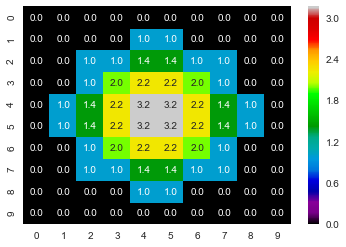

In [15]:
dmap = ndimage.distance_transform_edt(img_bw)
sns.heatmap(dmap, annot=True,
            fmt="2.1f", cmap='nipy_spectral')

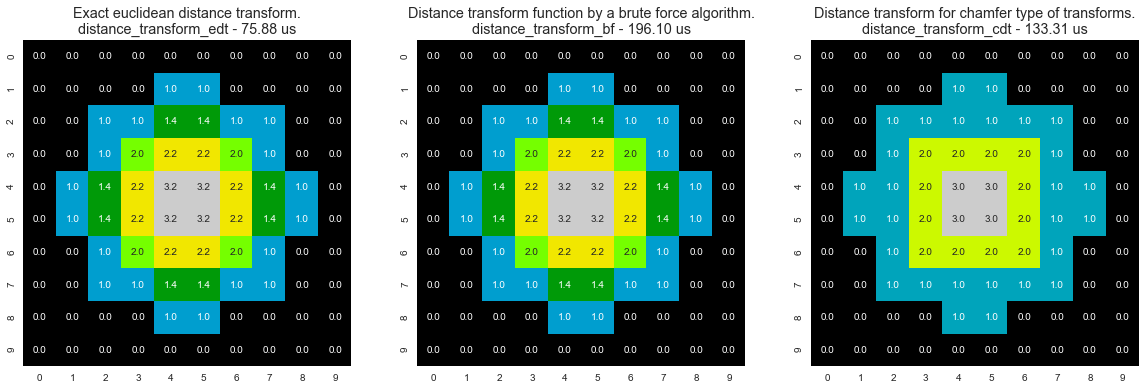

In [16]:
from timeit import timeit
dmap_list = [ndimage.distance_transform_edt,
             ndimage.distance_transform_bf, ndimage.distance_transform_cdt]
fig, m_axs = plt.subplots(1, len(dmap_list), figsize=(20, 6))
for dmap_func, c_ax in zip(dmap_list, m_axs):
    ms_time = timeit(lambda: dmap_func(img_bw), number=10000)/10000*1e6
    dmap = dmap_func(img_bw)
    sns.heatmap(dmap, annot=True,
                fmt="2.1f", cmap='nipy_spectral', ax=c_ax, cbar=False)
    c_ax.set_title('{}\n{} - {} us'.format(dmap_func.__doc__.split('\n')[1].strip(),
                                           dmap_func.__name__,
                                           '%2.2f' % ms_time))

# Why does speed matter?
As for the question why speed matters, for small images clearly the more efficient approaches don't make much of a difference, but when we start to look at data from a Synchrotron measurement 2160x2560x2560 (SLS) this becomes much more important

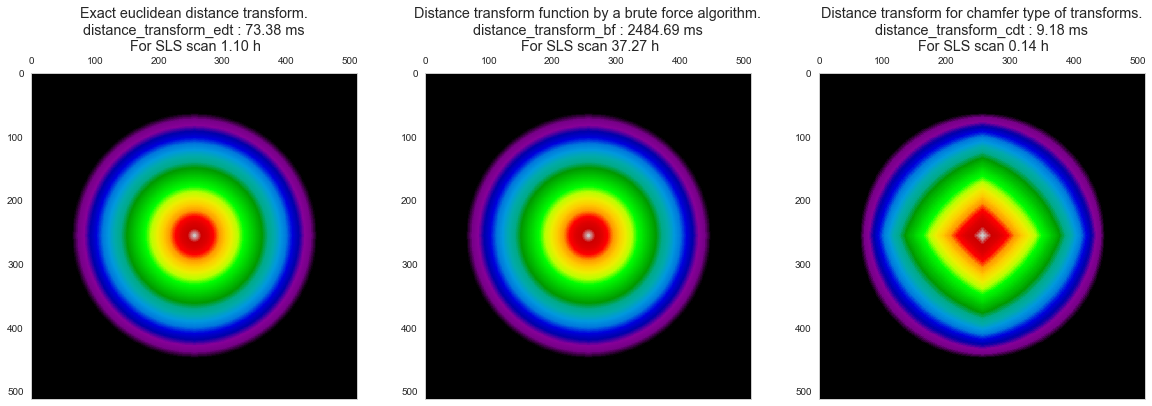

In [6]:
img_bw = generate_dot_image(512, 0.75)
sls_fact = 2160*2560*2560/np.prod(img_bw.shape)
dmap_list = [ndimage.distance_transform_edt,
             ndimage.distance_transform_bf, ndimage.distance_transform_cdt]
fig, m_axs = plt.subplots(1, len(dmap_list), figsize=(20, 6))
for dmap_func, c_ax in zip(dmap_list, m_axs):
    ms_time = timeit(lambda: dmap_func(img_bw), number=1)*1e3
    dmap = dmap_func(img_bw)
    c_ax.matshow(dmap, cmap='nipy_spectral')
    c_ax.set_title('{}\n{} : {} ms\n For SLS scan {} h'.format(dmap_func.__doc__.split('\n')[1].strip(),
                                                               dmap_func.__name__,
                                                               '%2.2f' % ms_time,
                                                               '%2.2f' % (ms_time*sls_fact/3600/1e3)))

### Definition
If we start with an image as a collection of points divided into two categories 
- $Im(x,y)=$ {Foreground, Background}
- We can define a distance map operator ($dist$) that transforms the image into a distance map

$$ dist(\vec{x}) = \textrm{min}(||\vec{x}-\vec{y}|| \forall \vec{y} \in \textrm{Background}) $$

We will use Euclidean distance $||\vec{x}-\vec{y}||$ for this class but there are other metrics which make sense when dealing with other types of data like Manhattan/City-block or weighted metrics.

In [17]:
def simple_distance_iteration(last_img):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] >= 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                p_dist = np.sqrt(np.square(xp)+np.square(yp))
                                if cur_img[x+xp, y+yp] > (last_img[x, y]+p_dist):
                                    cur_img[x+xp, y+yp] = last_img[x, y]+p_dist
    return cur_img

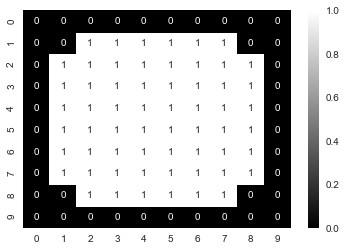

In [18]:
img_bw = generate_dot_image(10, 1.0)
sns.heatmap(img_bw, annot=True,
            fmt="d", cmap='gray')

In [19]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
img_base = (img_bw*255).astype(np.float32)
img_list = []
for i in range(5):
    img_base = simple_distance_iteration(img_base)
    img_list += [img_base]


def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="2.1f",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=0,
                vmax=5)
    c_ax.set_title('Iteration #{}'.format(i+1))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=5,
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Distance Maps: Types

Using this rule a distance map can be made for the euclidean metric 


Similarly the Manhattan or city block distance metric can be used where the distance is defined as 
$$ \sum_{i} |\vec{x}-\vec{y}|_i $$

In [20]:
def simple_distance_iteration(last_img):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] >= 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                p_dist = np.abs(xp)+np.abs(yp)
                                if cur_img[x+xp, y+yp] > (last_img[x, y]+p_dist):
                                    cur_img[x+xp, y+yp] = last_img[x, y]+p_dist
    return cur_img

In [21]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
img_base = (img_bw*255).astype(np.float32)
img_list = [img_base]
for i in range(5):
    img_base = simple_distance_iteration(img_base)
    img_list += [img_base]


def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="2.0f",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=0,
                vmax=5)
    c_ax.set_title('Iteration #{}'.format(i+1))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=5,
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Distance Maps: Precaution


The distance map is one of the crictical points where the resolution of the imaging system is important. 
- We measure distances computationally in pixels or voxels
- but for them to have a meaning physically they must be converted
 - Isotropic imaging (1 $\mu$ m x 1$\mu$ m x 1 $\mu$ m) is __fine__
 
***

### Anisotropic
Ideally 

- as part of filtering, resample and convert to an isotropic scale. 

If that is not possible 

- custom distance map algorithms which use the side-lengths of the voxels to calculate distance rather than assuming 1x1x1

# Distance Maps


We can create 2 distance maps

1. Foreground $\rightarrow$ Background 
 - Information about the objects size and interior

1. Background $\rightarrow$ Foreground 
 - Information about the distance / space between objects


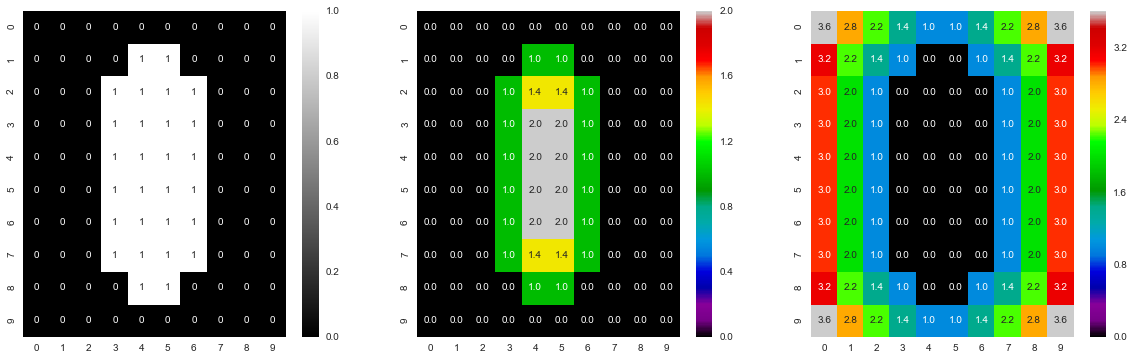

In [5]:
%matplotlib inline
import numpy as np
import skimage.transform
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import os


def generate_dot_image(size=100, rad_a=1, rad_b=None):
    xx, yy = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    if rad_b is None:
        rad_b = rad_a
    return np.sqrt(np.square(xx/rad_a)+np.square(yy/rad_b)) <= 1.0


img_bw = generate_dot_image(10, 0.5, 1.0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(img_bw, annot=True,
            fmt="d", cmap='gray', ax=ax1)
sns.heatmap(ndimage.distance_transform_edt(img_bw),
            annot=True,
            fmt="2.1f", cmap='nipy_spectral', ax=ax2)
sns.heatmap(ndimage.distance_transform_edt(1-img_bw),
            annot=True,
            fmt="2.1f", cmap='nipy_spectral', ax=ax3)
ax1.hist

# Distance Map

One of the most useful components of the distance map is that it is _relatively_ insensitive to small changes in connectivity.
- Component Labeling would find radically different results for these two images
 - One has 4 small circles
 - One has 1 big blob


In [28]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, m_axs = plt.subplots(2, 3, figsize=(10, 8), dpi=100)

img_list = []
for i in np.linspace(0.6, 1.3, 7):
    img_bw = np.concatenate([generate_dot_image(12, 0.7, i),
                             generate_dot_image(12, 0.6, i)], 0)
    img_base = ndimage.distance_transform_edt(img_bw)
    img_list += [img_base]


def update_frame(i):
    [tax.cla() for tax in m_axs.flatten()]
    ((c_ax, c_hist, c_dmean), (c_lab, c_labhist, c_lmean)) = m_axs
    sns.heatmap(img_list[i],
                annot=True,
                fmt="2.0f",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=0,
                vmax=5)
    c_ax.set_title('DMap #{}'.format(i+1))
    c_hist.hist(img_list[i].ravel(),
                np.linspace(0, 3, 6))
    c_hist.set_title('Mean: %2.2f\nStd: %2.2f' % (np.mean(img_list[i][img_list[i] > 0]),
                                                  np.std(img_list[i][img_list[i] > 0])))

    c_dmean.plot(range(i+1), [np.mean(img_list[k][img_list[k] > 0])
                              for k in range(i+1)], 'r+-')
    c_dmean.set_ylim(0, 2)
    c_dmean.set_title('Avergage Distance')

    lab_img = ndimage.label(img_list[i] > 0)[0]

    sns.heatmap(lab_img,
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_lab,
                cbar=False,
                vmin=0,
                vmax=2)
    c_lab.set_title('Component Labeled')

    def avg_area(c_img):
        l_img = ndimage.label(c_img > 0)[0]
        return np.mean([np.sum(l_img == k) for k in range(1, l_img.max()+1)])
    n, _, _ = c_labhist.hist(lab_img[lab_img > 0].ravel(), [
                             0, 1, 2, 3], rwidth=0.8)
    c_labhist.set_title('# Components: %d\nAvg Area: %d' %
                        (lab_img.max(), avg_area(img_list[i])))

    c_lmean.plot(range(i+1),
                 [avg_area(img_list[k]) for k in range(i+1)], 'r+-')
    c_lmean.set_ylim(0, 150)
    c_lmean.set_title('Average Area')


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list)-1,
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

# Distance Map of Real Images

We now have a basic idea of how the distance map works we can now try to apply it to real images

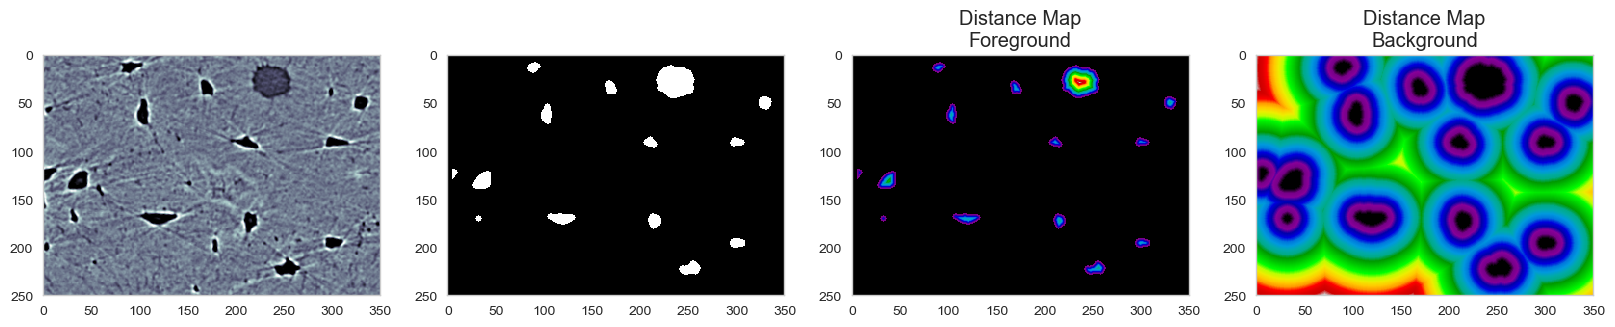

In [55]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
bw_img = imread("ext-figures/bonegfiltslice.png")
from skimage.morphology import binary_opening, binary_closing, disk
thresh_img = binary_closing(binary_opening(bw_img<90, disk(3)), disk(5))
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 6), dpi = 100)
ax1.imshow(bw_img, cmap = 'bone')
ax2.imshow(thresh_img, cmap = 'bone')
ax3.set_title('Segmentation')
ax3.imshow(fg_dmap, cmap = 'nipy_spectral')
ax3.set_title('Distance Map\nForeground')
ax4.imshow(bg_dmap, cmap = 'nipy_spectral')
ax4.set_title('Distance Map\nBackground');

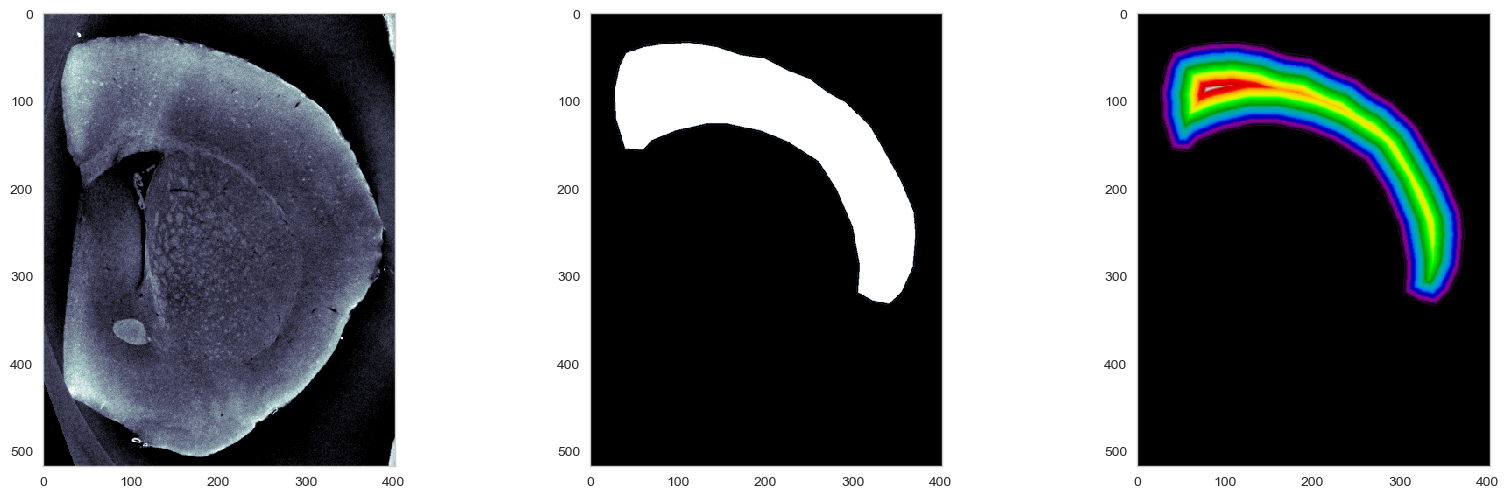

In [46]:
cortex_img = imread("ext-figures/example_poster.tif")[::2, ::2]/2048
cortex_mask = imread("ext-figures/example_poster_mask.tif")[::1, ::1, 0]/255.0
cortex_dmap = distance_transform_edt(cortex_mask)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6), dpi = 100)

ax1.imshow(cortex_img, cmap = 'bone')
ax2.imshow(cortex_mask, cmap = 'bone')
ax3.imshow(cortex_dmap, cmap = 'nipy_spectral');

## How can we utilize this information?
So we can see in the distance map some information about the size of the object, but the raw values and taking a histogram do not seem to provide this very clearly


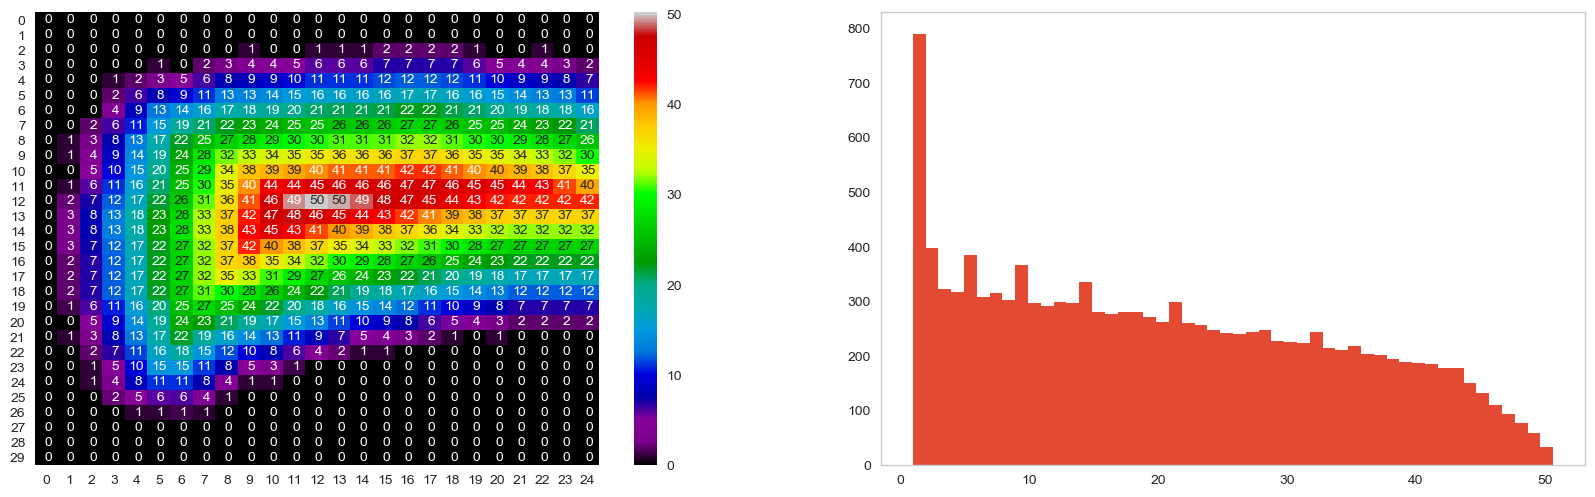

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6), dpi = 100)
cortex_dmap_roi = cortex_dmap[25:175, 25:150]
sns.heatmap(cortex_dmap_roi[::5, ::5],
                annot=True,
                fmt="2.0f",
                cmap='nipy_spectral',
                ax=ax1,
                cbar=True)

ax2.hist(cortex_dmap_roi[cortex_dmap_roi>0].ravel(), 50);

# Thickness Map: What is it?

Thickness is a metric for assessing the size and structure of objects in a very generic manner. 
For every point $\vec{x}$ in the image you find the largest sphere which:
- contains that point
- is entirely contained within the object

***

![Thickness Diagram](ext-figures/ThickOverview.png) 
Taken from [1]

- The image shows a typical object
- The sphere centered at point $p$ with a radius $r$ is the largest that fits

### Application

- Ideal for spherical and cylindrical objects since it shows their radius
- Also relevant for flow and diffusion since it can highlight bottlenecks in structure

# Thickness Map


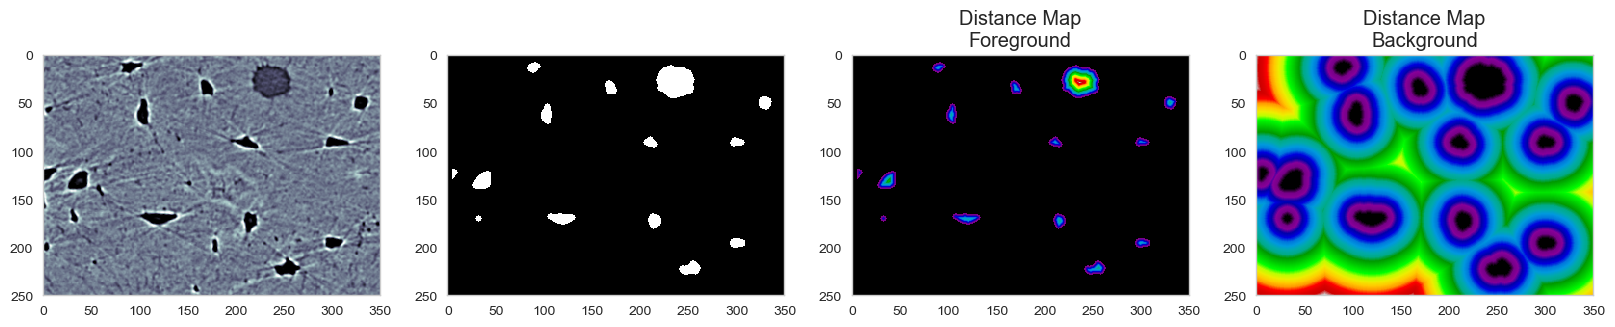

In [56]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
bw_img = imread("ext-figures/bonegfiltslice.png")
from skimage.morphology import binary_opening, binary_closing, disk
thresh_img = binary_closing(binary_opening(bw_img<90, disk(3)), disk(5))
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 6), dpi = 100)
ax1.imshow(bw_img, cmap = 'bone')
ax2.imshow(thresh_img, cmap = 'bone')
ax3.set_title('Segmentation')
ax3.imshow(fg_dmap, cmap = 'nipy_spectral')
ax3.set_title('Distance Map\nForeground')
ax4.imshow(bg_dmap, cmap = 'nipy_spectral')
ax4.set_title('Distance Map\nBackground');

In [62]:
def fill_circle(x, y, rad):
    np.square(xx-x)+np.square(yy-y)<rad
def simple_thickness_iteration(distance_map, thickness_map = None):
    if thickness_map is None:
        th_map = distance_map.copy()
    else:
        th_map = thickness_map.copy()
    xx, yy = np.meshgrid(range(distance_map.shape[0]),
                         range(distance_map.shape[1]))
    
    
    return cur_img
-np.sort(-np.eye(3).ravel())

array([1., 1., 1., 0., 0., 0., 0., 0., 0.])

Thickness Map
===
```{r, fig.cap="Cell Distance Map",fig.height=6}
dmap.bg<-dist.map(fill.img,fg.ph=0,bg.ph=155)
ggplot(dmap.bg,aes(x=x,y=y,fill=dist))+
  geom_tile(color="black")+
  labs(title="Single Cell",fill="Distance\nFrom\nSurface")+
  th_fillmap.fn(max(dmap.bg$dist))+
  theme_bw(20)+coord_equal()
```

***

```{r, fig.cap="Cell Distance Map",fig.height=6}
ggplot(thick.map(dmap.bg),aes(x=x,y=y,fill=sph.rad))+
  geom_tile(color="black")+
  labs(title="Single Cell",fill="Sphere\nRadius")+
  th_fillmap.fn(max(dmap.bg$dist))+
  theme_bw(20)+coord_equal()
```

# Thickness in 3D Images
===

While the examples and demonstrations so far have been shown in 2D, the same exact technique can be applied to 3D data as well. For example for this liquid foam structure

![Liquid Foam Plateau Border](ext-figures/3dfoam.png)

***
- The thickness can be calculated of the background (air) voxels in the same manner.

- With care, this can be used as a proxy for bubble size distribution in systems where all the bubbles are connected to it is difficult to identify single ones.


![Liquid Foam Thickness](ext-figures/thk3dfoam.png)

# Interfaces / Surfaces

Many physical and chemical processes occur at surfaces and interfaces and consequently these structures are important in material science and biology. For this lecture surface and interface will be used interchangebly and refers to the boundary between two different materials (calcified bone and soft tissue, magma and water, liquid and gas) Through segmentation we have identified the unique phases in the sample under investigation. 

- Segmentation identifying volumes (3D) or areas (2D)
- Interfaces are one dimension lower corresponding to surface area (3D) or perimeter (2D)
- Interfaces are important for 
 - connectivity of cell networks, particularly neurons
 - material science processes like coarsening or rheological behavior
 - chemical processes (surface-bound diffusion, catalyst action)

# Surface Area / Perimeter

We see that the dilation and erosion affects are strongly related to the surface area of an object: the more surface area the larger the affect of a single dilation or erosion step. 

# Meshing


Constructing a mesh for an image provides very different information than the image data itself. Most crucially this comes when looking at physical processes like deformation.

While the images are helpful for visualizing we rarely have models for quantifying how difficult it is to turn a pixel __off__

If the image is turned into a mesh we now have a list of vertices and edges. For these vertices and edges we can define forces. For example when looking at stress-strain relationships in mechanics using Hooke's Model 
$$ \vec{F}=k (\vec{x}_0-\vec{x}) $$ 
the force needed to stretch one of these edges is proportional to how far it is stretched. 

# Marching Cubes

### Why
Voxels are very poor approximations for the surface and are very rough (they are either normal to the x, y, or z axis and nothing between). Because of their inherently orthogonal surface normals, any analysis which utilizes the surface normal to calculate another value (growth, curvature, etc) is going to be very inaccurate at best and very wrong at worst.

### [How](http://en.wikipedia.org/wiki/Marching_cubes)
The image is processed one voxel at a time and the neighborhood (not quite the same is the morphological definition) is checked at every voxel. From this configuration of values, faces are added to the mesh to incorporate the most simple surface which would explain the values. 

[Marching tetrahedra](http://en.wikipedia.org/wiki/Marching_tetrahedra) is for some applications a better suited approach

Curvature
===

Curvature is a metric related to the surface or interface between phases or objects. 
- It is most easily understood in its 1D sense or being the radius of the circle that matchs the local shape of a curve

![Curvature-Wikipedia](http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Osculating_circle.svg/250px-Osculating_circle.svg.png)

- Mathematically it is defined as 

$$ \kappa = \frac{1}{R} $$

- Thus a low curvature means the value means a very large radius and high curvature means a very small radius


Curvature: Surface Normal
===

In order to meaningfully talk about curvatures of surfaces, we first need to define a consistent frame of reference for examining the surface of an object. We thus define a surface normal vector as a vector oriented orthogonally to the surface away from the interior of the object $\rightarrow \vec{N}$


![Surface](ext-figures/3Dsurface.png)
![Surface Normals](ext-figures/3DsurfaceWiNormals.png)

Curvature: 3D
===
With the notion of surface normal defined ($\vec{N}$), we can define many curvatures at point $\vec{x}$ on the surface. 
- This is because there are infinitely many planes which contain both point $\vec{x}$ and $\vec{N}$ 
- More generally we can define an angle $\theta$ about which a single plane containing both can be freely rotated
- We can then define two principal curvatures by taking the maximum and minimum of this curve

$$ \kappa_1 = \textrm{max}(\kappa(\theta)) $$
$$ \kappa_2 = \textrm{min}(\kappa(\theta)) $$

***

### Mean Curvature
The mean of the two principal curvatures
$$ H = \frac{1}{2}(\kappa_1+\kappa_2) $$

### Gaussian Curvature

The mean of the two principal curvatures
$$ K = \kappa_1\kappa_2 $$
- positive for spheres (or spherical inclusions)
 - curvatures agree in sign
- negative for saddles (hyperboloid surfaces)
 - curvatures disgree in sign
- 0 for planes

Curvature: 3D Examples
===
Examining a complex structure with no meaningful ellipsoidal or watershed model. The images themselves show the type of substructures and shapes which are present in the sample. 


![Mean Curvature](ext-figures/Complicated3DsurfaceMCurv.png)


***

- gaussian curvature:  the comparative amount of surface at, above, and below 0 
 - from spherical particles into annealed mesh of balls

![Gaussian Curvature](ext-figures/Complicated3DsurfaceGCurv.png)



Characteristic Shape
===

Characteristic shape can be calculated by measuring principal curvatures and normalizing them by scaling to the structure size. A distribution of these curvatures then provides shape information on a structure indepedent of the size. 

For example a structure transitioning from a collection of perfectly spherical particles to a annealed solid will go from having many round spherical faces with positive gaussian curvature to many saddles and more complicated structures with 0 or negative curvature.


Curvature: Take Home Message
===
It provides another metric for characterizing complex shapes
- Particularly useful for examining interfaces
 - Folds, saddles, and many other types of points are not characterized well be ellipsoids or thickness maps
- Provides a scale-free metric for assessing structures
- Can provide visual indications of structural changes

Other Techniques
===

There are hundreds of other techniques which can be applied to these complicated structures, but they go beyond the scope of this course. Many of them are model-based which means they work well but only for particular types of samples or images. Of the more general techniques several which are easily testable inside of FIJI are 
- Directional Analysis = Looking at the orientation of different components using Fourier analysis (_Analyze_ $\rightarrow$ _Directionality_)
- Tubeness / Surfaceness (_Plugins_ $\rightarrow$ _Analyze_ $\rightarrow$) characterize binary images and the shape at each point similar to curvature but with a different underlying model

*** 
- Fractal Dimensionality = A metric for assessing the structure as you scale up and down by examining various spatial relationships
 - Ma, D., Stoica, A. D., & Wang, X.-L. (2009). Power-law scaling and fractal nature of medium-range order in metallic glasses. Nature Materials, 8(1), 30–4. doi:10.1038/nmat2340
- Two (or more) point correlation functions = Used in theoretical material science and physics to describe random materials and can be used to characterize distances, orientations, and organization in complex samples 
 - Jiao, Y., Stillinger, F., & Torquato, S. (2007). Modeling heterogeneous materials via two-point correlation functions: Basic principles. Physical Review E, 76(3). doi:10.1103/PhysRevE.76.031110
 - Andrey, P., Kiêu, K., Kress, C., Lehmann, G., Tirichine, L., Liu, Z., … Debey, P. (2010). Statistical analysis of 3D images detects regular spatial distributions of centromeres and chromocenters in animal and plant nuclei. PLoS Computational Biology, 6(7), e1000853. doi:10.1371/journal.pcbi.1000853
 - Haghpanahi, M., & Miramini, S. (2008). Extraction of morphological parameters of tissue engineering scaffolds using two-point correlation function, 463–466. Retrieved from http://portal.acm.org/citation.cfm?id=1713360.1713456
 
 
Texture Analysis
===

http://murphylab.web.cmu.edu/publications/boland/boland_node26.html

Sample Textures
===

```{r}
text_imgs<-expand.grid(x=1:16,y=1:16) %>%
  mutate(val_x=x%%2,
         val_y=y%%2,
         val_xy=(x%%2+y%%2)/2.0,
         val_x2y=(x%%4+y%%2)/2.5,
         val_x2y2=(x%%4+y%%3)/3.5,
         val_xya=(x+y)%%3/2.0) %>%
  melt(id.vars=c("x","y"))
text_imgs %>%  ggplot(aes(x,y))+
  geom_raster(aes(fill=value))+
  facet_wrap(~variable)+
  coord_equal()+
  theme_bw(10)
```

```{r}
text_imgs %>% ggplot(aes(value))+
  geom_density(aes(fill=variable),alpha=0.5)+
  theme_bw(10)
```

Co-occurrence matrix
===

$$
C_{\Delta x, \Delta y}(i,j)=\sum_{x=1}^n\sum_{y=1}^m\begin{cases} 1, & \text{if }I(x, y)=i\text{ and }I(x+\Delta x, y+\Delta y)=j \\ 0, & \text{otherwise}\end{cases}
$$

- As text $\rightarrow$ for every possible offset $\vec{r}$ = ($\Delta x$, $\Delta y$) given the current intensity ($i$) how likely is it that value at a point offset by that amount is $j$.
- This is similar to the two point correlation function but is a 4D representation instead of just a 2D
- In order to use this we need to discretize the image into bins

```{r}
bin_it<-function(x) as.numeric(as.factor(cut_interval(x,4)))
bin_image<-text_imgs %>% 
  mutate(value=bin_it(value)) 
bin_image %>%
  group_by(variable,value) %>%
  summarize(count=n()) %>%
  ggplot(aes(value,count))+
  geom_bar(aes(fill=variable),alpha=0.5,stat="identity",pos="dodge")+
  facet_grid(~variable)+
  theme_bw(10)
```

Calculating the Matrix
===

```{r}
bin_image %>% 
  merge(bin_image,by=c("variable")) %>% 
  mutate(dx=x.y-x.x,dy=y.y-y.x) %>% 
  subset((abs(dx)<4) & (abs(dy)<4)) %>%
  group_by(variable,dx,dy,value.x,value.y) %>%
  summarize(count=n()) %>%
  mutate(ij=paste0(value.x,"->",value.y)) %>%
  ggplot(aes(dx,dy))+
  geom_raster(aes(fill=count))+
  facet_grid(variable~ij)+
  theme_bw(10)
```

Overlapping
===

```{r}
bin_image %>% 
  merge(bin_image,by=c("variable")) %>% 
  mutate(dx=x.y-x.x,dy=y.y-y.x) %>% 
  subset((abs(dx)<5) & (abs(dy)<5)) %>%
  group_by(variable,dx,dy,value.x,value.y) %>%
  summarize(count=n()) %>%
  mutate(ij=paste0(value.x,"->",value.y)) %>%
  ggplot(aes(dx,dy))+
  geom_contour(aes(z=count,color=ij))+
  facet_wrap(~variable)+
  theme_bw(10)
```

Simple Correlation
===
Using the mean difference ($E[i-j]$) instead of all of the i,j pair possiblities 

```{r}
bin_image %>% 
  merge(bin_image,by=c("variable")) %>% 
  mutate(dx=x.y-x.x,dy=y.y-y.x,dv=value.y-value.x) %>% 
  subset((abs(dx)<4) & (abs(dy)<4)) %>%
  group_by(variable,dx,dy,value.x,value.y) %>%
  summarize(score=mean(dv)) %>%
  ggplot(aes(dx,dy))+
  geom_raster(aes(fill=score))+
  facet_wrap(~variable)+
  coord_equal()+
  theme_bw(10)
```

Radial Coordinates
===
Rather than using $\Delta x$ and $\Delta y$ we can also show the relative positions 

```{r}
bin_image %>% 
  merge(bin_image,by=c("variable")) %>% 
  mutate(dr=sqrt((x.y-x.x)**2+(y.y-y.x)**2),
         dtheta=180/pi*atan((y.y-y.x)/(x.y-x.x)),
         dv=value.y-value.x) %>% 
  subset(dr<6 & !is.na(dtheta)) %>%
  mutate(dr=cut_interval(dr,10),
         dtheta=cut_interval(dtheta,8)) %>%
  group_by(variable,dr,dtheta,value.x,value.y) %>%
  summarize(score=mean(dv)) %>%
  ggplot(aes(dtheta,dr))+
  geom_tile(aes(fill=score))+
  facet_wrap(~variable)+
  coord_polar(theta="x")+
  scale_fill_distiller(palette = "Spectral")+
  theme_bw(10)
```